In [1]:
from VAE.dataset import MNISTDataModule
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import math
from tqdm import tqdm

import torchvision
import matplotlib.pyplot as plt
# from torcheval.metrics import FrechetInceptionDistance as FID

from torch import Tensor
def _calculate_frechet_distance(
        mu1: Tensor,
        sigma1: Tensor,
        mu2: Tensor,
        sigma2: Tensor,
    ) -> Tensor:
        """
        Calculate the Frechet Distance between two multivariate Gaussian distributions.

        Args:
            mu1 (Tensor): The mean of the first distribution.
            sigma1 (Tensor): The covariance matrix of the first distribution.
            mu2 (Tensor): The mean of the second distribution.
            sigma2 (Tensor): The covariance matrix of the second distribution.

        Returns:
            tensor: The Frechet Distance between the two distributions.
        """

        # Compute the squared distance between the means
        mean_diff = mu1 - mu2
        mean_diff_squared = mean_diff.square().sum(dim=-1)

        # Calculate the sum of the traces of both covariance matrices
        trace_sum = sigma1.trace() + sigma2.trace()

        # Compute the eigenvalues of the matrix product of the real and fake covariance matrices
        sigma_mm = torch.matmul(sigma1, sigma2)
        eigenvals = torch.linalg.eigvals(sigma_mm)

        # Take the square root of each eigenvalue and take its sum
        sqrt_eigenvals_sum = eigenvals.sqrt().real.sum(dim=-1)

        # Calculate the FID using the squared distance between the means,
        # the sum of the traces of the covariance matrices, and the sum of the square roots of the eigenvalues
        fid = mean_diff_squared + trace_sum - 2 * sqrt_eigenvals_sum

        return fid


def _calculate_FID_SCORE(images_real, images_synthetic):
    images_real = images_real.view(images_real.size(0), -1).T
    images_synthetic = images_synthetic.view(images_synthetic.size(0), -1).T
    images_real.shape, images_synthetic.shape
    mu_real = images_real.mean(dim=1)
    sigma_real = torch.cov(images_real)

    mu_synthetic = images_synthetic.mean(dim=1)
    sigma_synthetic = torch.cov(images_synthetic)
    return _calculate_frechet_distance(mu_real, sigma_real, mu_synthetic, sigma_synthetic)

class ChannelShuffle(nn.Module):
    def __init__(self,groups):
        super().__init__()
        self.groups=groups
    def forward(self,x):
        n,c,h,w=x.shape
        x=x.view(n,self.groups,c//self.groups,h,w) # group
        x=x.transpose(1,2).contiguous().view(n,-1,h,w) #shuffle
        
        return x

class ConvBnSiLu(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,stride=1,padding=0):
        super().__init__()
        self.module=nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding),
                                  nn.BatchNorm2d(out_channels),
                                  nn.SiLU(inplace=True))
    def forward(self,x):
        return self.module(x)

class ResidualBottleneck(nn.Module):
    '''
    shufflenet_v2 basic unit(https://arxiv.org/pdf/1807.11164.pdf)
    '''
    def __init__(self,in_channels,out_channels):
        super().__init__()

        self.branch1=nn.Sequential(nn.Conv2d(in_channels//2,in_channels//2,3,1,1,groups=in_channels//2),
                                    nn.BatchNorm2d(in_channels//2),
                                    ConvBnSiLu(in_channels//2,out_channels//2,1,1,0))
        self.branch2=nn.Sequential(ConvBnSiLu(in_channels//2,in_channels//2,1,1,0),
                                    nn.Conv2d(in_channels//2,in_channels//2,3,1,1,groups=in_channels//2),
                                    nn.BatchNorm2d(in_channels//2),
                                    ConvBnSiLu(in_channels//2,out_channels//2,1,1,0))
        self.channel_shuffle=ChannelShuffle(2)

    def forward(self,x):
        x1,x2=x.chunk(2,dim=1)
        x=torch.cat([self.branch1(x1),self.branch2(x2)],dim=1)
        x=self.channel_shuffle(x) #shuffle two branches

        return x

class ResidualDownsample(nn.Module):
    '''
    shufflenet_v2 unit for spatial down sampling(https://arxiv.org/pdf/1807.11164.pdf)
    '''
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.branch1=nn.Sequential(nn.Conv2d(in_channels,in_channels,3,2,1,groups=in_channels),
                                    nn.BatchNorm2d(in_channels),
                                    ConvBnSiLu(in_channels,out_channels//2,1,1,0))
        self.branch2=nn.Sequential(ConvBnSiLu(in_channels,out_channels//2,1,1,0),
                                    nn.Conv2d(out_channels//2,out_channels//2,3,2,1,groups=out_channels//2),
                                    nn.BatchNorm2d(out_channels//2),
                                    ConvBnSiLu(out_channels//2,out_channels//2,1,1,0))
        self.channel_shuffle=ChannelShuffle(2)

    def forward(self,x):
        x=torch.cat([self.branch1(x),self.branch2(x)],dim=1)
        x=self.channel_shuffle(x) #shuffle two branches

        return x

class TimeMLP(nn.Module):
    '''
    naive introduce timestep information to feature maps with mlp and add shortcut
    '''
    def __init__(self,embedding_dim,hidden_dim,out_dim):
        super().__init__()
        self.act=nn.SiLU()
        self.out_dim = out_dim
        self.size_map = {
            4: 2*28,
            8: 2*14,
            16: 2*14,
            32: 2*14,
            64: 14,
            256: 7
        }

        self.mlp=nn.Sequential(nn.Linear(embedding_dim,hidden_dim),
                                self.act,
                                nn.Linear(hidden_dim, self.size_map[out_dim]**2))
        
    def forward(self,t):
        
        t_emb=self.mlp(t).unsqueeze(1).view(-1, 1, self.size_map[self.out_dim], self.size_map[self.out_dim])
        # print('y_emb shape', y_emb.shape, 'x.shape', x.shape, 'out_dim', self.out_dim, 'hidden_dim', self.hidden_dim, 'embedding_dim', self.embedding_dim)
        return t_emb
    
class TargetMLP(nn.Module):
    def __init__(self,embedding_dim,hidden_dim,out_dim):
        super().__init__()
        self.out_dim = out_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        self.act= nn.SiLU()  # swish activation function: like in https://arxiv.org/pdf/2006.11239.pdf

        self.size_map = {

            4: 2*28,
            8: 2*14,
            16: 2*14,
            32: 2*14,
            64: 14,
            256: 7
        }

        self.mlp=nn.Sequential(nn.Linear(embedding_dim,hidden_dim),
                                self.act,
                                nn.Linear(hidden_dim, self.size_map[out_dim]**2))
        
        
    def forward(self,  y):
        y_emb = self.mlp(y).unsqueeze(1).view(-1, 1, self.size_map[self.out_dim], self.size_map[self.out_dim])
        # print('y_emb shape', y_emb.shape, 'x.shape', x.shape, 'out_dim', self.out_dim, 'hidden_dim', self.hidden_dim, 'embedding_dim', self.embedding_dim)
        return y_emb
        

class EncoderBlock(nn.Module):
    def __init__(self,in_channels,out_channels,time_embedding_dim, target_embedding_dim, verbose=False):
        super().__init__()

        self.conv_init_0=nn.Sequential(ConvBnSiLu(in_channels,in_channels,3,1,1))

        self.conv_cs0=nn.Sequential(*[ResidualBottleneck(in_channels,in_channels) for i in range(3)],
                                    ResidualBottleneck(in_channels,in_channels))
        
        self.conv_cs1=nn.Sequential(*[ResidualBottleneck(in_channels, in_channels) for i in range(3)],
                                    ResidualBottleneck(in_channels, in_channels))

        self.time_mlp=TimeMLP(embedding_dim=time_embedding_dim, hidden_dim=out_channels, out_dim=out_channels//2)
        self.target_mlp = TargetMLP(embedding_dim=target_embedding_dim, 
                                    hidden_dim = out_channels, out_dim=out_channels//2)
        self.conv1=ResidualDownsample(out_channels//2,out_channels)
        self.conv2=ResidualDownsample(out_channels//2,out_channels)
        self.verbose = verbose

        self.act = nn.SiLU()
    
    def forward(self,x,t=None, y=None):

        # add timestep to x
        if self.verbose: print('ENCODER: initial sizes:', 'x:', x.shape,'\tt:', t.shape, '\ty:', y.shape)
        t=self.time_mlp(t)
        if self.verbose: print('ENCODER: aft. time_mlp:', 'x:', x.shape,'\tt:', t.shape, '\ty:', y.shape)
        x = x+t
        x = self.act(x)
        x = self.conv_init_0(x)
        if self.verbose: print('ENCODER: aft. conv_init_0:', 'x:', x.shape,'\tt:', t.shape, '\ty:', y.shape)
        x = self.conv_cs0(x)
        if self.verbose: print('ENCODER: aft. conv_cs0:', 'x:', x.shape,'\tt:', t.shape, '\ty:', y.shape)
        # add target to x
        y = self.target_mlp(y)
        if self.verbose: print('ENCODER: aft. target_mlp:', 'x:', x.shape, 't:', t.shape, 'y:', y.shape)
        x = x + y
        x = self.act(x)
        x = self.conv_cs1(x)
        x_shortcut = x.clone()  # we clone before downsampling

        if self.verbose: print('ENCODER: aft. conv_cs1:', 'x:', x.shape, 't:', t.shape, 'y:', y.shape)
        # downsample
        x=self.conv1(x)
        if self.verbose: print('ENCODER: aft. conv1:', 'x:', x.shape, 't:', t.shape, 'y:', y.shape)
        return [x, x_shortcut]
        
class DecoderBlock(nn.Module):
    def __init__(self,in_channels,out_channels,time_embedding_dim, target_embedding_dim):
        super().__init__()
        self.upsample=nn.Upsample(scale_factor=2,mode='bilinear',align_corners=False)
        self.conv0=nn.Sequential(*[ResidualBottleneck(in_channels,in_channels) for i in range(3)],
                                    ResidualBottleneck(in_channels,in_channels//2))

        self.time_mlp=TimeMLP(embedding_dim=time_embedding_dim,hidden_dim=in_channels,out_dim=in_channels//2)
        self.target_mlp = TargetMLP(embedding_dim=target_embedding_dim, 
                                    hidden_dim = in_channels, out_dim=in_channels//2)
        self.conv1=ResidualBottleneck(in_channels//2,in_channels//2)
        self.conv2=ResidualBottleneck(in_channels//2,out_channels//2)

        self.act = nn.SiLU()

    def forward(self,x,x_shortcut,t=None, y=None):
        x=self.upsample(x)
        x=torch.cat([x,x_shortcut],dim=1)
        x=self.conv0(x)
        t = self.time_mlp(t)
        y = self.target_mlp(y)
        x = x+t
        x = self.act(x)

        x=self.conv1(x)
        x = x + y
        x = self.act(x)
        x=self.conv2(x)
        return x        

class Unet(nn.Module):
    '''
    unet design with target input
    '''
    def __init__(self,timesteps,time_embedding_dim, in_channels=1,out_channels=1,base_dim=32,dim_mults=[2,4,8,16], verbose=False):
        super().__init__()
        assert isinstance(dim_mults,(list,tuple))
        assert base_dim%2==0 

        channels=self._cal_channels(base_dim,dim_mults)
        # print('channels', channels)

        self.init_conv=ConvBnSiLu(in_channels,base_dim,3,1,1)
        self.time_embedding=nn.Embedding(timesteps,time_embedding_dim)
        targets = 10
        target_embedding_dim = 10

        self.target_embedding=nn.Embedding(targets,target_embedding_dim)

        self.encoder_blocks=nn.ModuleList([EncoderBlock(c[0],c[1],time_embedding_dim, target_embedding_dim, verbose=verbose) for c in channels])
        self.decoder_blocks=nn.ModuleList([DecoderBlock(c[1],c[0],time_embedding_dim, target_embedding_dim) for c in channels[::-1]])
    
        self.mid_block=nn.Sequential(*[ResidualBottleneck(channels[-1][1],channels[-1][1]) for i in range(2)],
                                        ResidualBottleneck(channels[-1][1],channels[-1][1]//2))

        self.final_conv=nn.Conv2d(in_channels=channels[0][0]//2,out_channels=out_channels,kernel_size=1)

        self.dropout=nn.Dropout(0.1)
        self.verbose = verbose
    def forward(self,x,t, y):
        """
        Changes we wanna make:
        1. only add target at mid block and decoder blocks
        2. add time embedding to all blocks (using addition rather than concatenation)
        
        """
        if self.verbose: print('initial sizes:', 'x:', x.shape,'\tt:', t.shape, '\ty:', y.shape)
        x=self.init_conv(x)  # 1, 28, 28 -> 32, 28, 28
        if self.verbose: print('aft. init_conv:', 'x:', x.shape,'\tt:', t.shape, '\ty:', y.shape)
        
        # embed time and target
        t=self.time_embedding(t)    
        y = self.target_embedding(y)
        if self.verbose: print('aft. embedding:', 'x:', x.shape,'\tt:', t.shape, '\ty:', y.shape)

        encoder_shortcuts=[]
        for encoder_block in self.encoder_blocks:
            x,x_shortcut=encoder_block(x, t, y)
            encoder_shortcuts.append(x_shortcut)
            x=self.dropout(x)
        
        x=self.mid_block(x)


        encoder_shortcuts.reverse()
        for decoder_block,shortcut in zip(self.decoder_blocks,encoder_shortcuts):
            x=decoder_block(x, shortcut, t, y)
            x=self.dropout(x)
        x=self.final_conv(x)

        return x

    def _cal_channels(self,base_dim,dim_mults):
        dims=[base_dim*x for x in dim_mults]
        # print('dims', dims)
        dims.insert(0,base_dim)
        channels=[]
        for i in range(len(dims)-1):
            channels.append((dims[i],dims[i+1])) # in_channel, out_channel

        return channels

class ImageDiffusion(nn.Module):
    def __init__(
        self,
        timesteps=1000,
        time_embedding_dim=64,
        noise_schedule_method='cosine',
        epsilon=0.008,
        beta_start=1e-5,
        beta_end=0.004,
        base_dim=32,
    ):
        super().__init__()
        self.timesteps = timesteps
        self.time_embedding_dim = time_embedding_dim

        self.model = Unet(
            timesteps = timesteps,
            time_embedding_dim=time_embedding_dim,
            in_channels=1,
            out_channels=1,
            base_dim=base_dim,
            dim_mults=[2, 4,]
        )

        self.shape = (-1, 1, 28, 28)

        self.initialize_noise_schedule(noise_schedule_method, epsilon=epsilon, beta_start=beta_start, beta_end=beta_end)

    def initialize_noise_schedule(self, method, **kwargs): 
        # precalculate noise schedule
        if method =='cosine':
            betas = self._cosine_variance_schedule(self.timesteps, kwargs.get('epsilon', 0.008))
        elif method == 'square':
            betas = self._sqr_variance_schedule(self.timesteps, kwargs.get('beta_start', 1e-5), kwargs.get('beta_end', 0.004))
        else:
            raise ValueError('method must be either "cosine" or "square"')
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=-1)
        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)
        self.register_buffer("sqrt_alphas_cumprod", torch.sqrt(alphas_cumprod))
        self.register_buffer("sqrt_one_minus_alphas_cumprod", torch.sqrt(1.0 - alphas_cumprod))

    
    def forward(self, x, y, noise):
        # x:NCHW
        t = torch.randint(0, self.timesteps, (x.shape[0],)).to(x.device)
        x_t = self._forward_diffusion(x, t, noise)
        return self.model(x_t, t=t, y=y)

    @torch.no_grad()
    def sampling(self,n_samples,clipped_reverse_diffusion=True,device="mps", y=True, tqdm_disable=True):
        x_t = torch.randn( (n_samples, *self.shape[1:]), device=device, dtype=torch.float32)
        hist = []
        hist.append(x_t)

        if y:
            y = torch.randint(0, 10, (n_samples,)).to(device)
        else:
            y = None

        for i in tqdm(range(self.timesteps-1,-1,-1),desc="Sampling", disable=tqdm_disable):
            noise=torch.randn_like(x_t).to(device)
            t=torch.tensor([i for _ in range(n_samples)], device=device, dtype=torch.long)

            if clipped_reverse_diffusion:
                x_t=self._reverse_diffusion_with_clip(x_t, y, t, noise)
            else:
                x_t=self._reverse_diffusion(x_t, y, t, noise)

            hist.append(x_t)

        # x_t=(x_t+1.)/2. #[-1,1] to [0,1]

        hist=torch.stack(hist,dim=0)

        return x_t, hist, y
    
    def _cosine_variance_schedule(self, timesteps, epsilon=0.008):
        steps = torch.linspace(0, timesteps, steps=timesteps + 1, dtype=torch.float32)
        f_t = (
            torch.cos(((steps / timesteps + epsilon) / (1.0 + epsilon)) * math.pi * 0.5)
            ** 2
        )
        betas = torch.clip(1.0 - f_t[1:] / f_t[:timesteps], 0.0, 0.999)

        return betas
    
    def _sqr_variance_schedule(self, timesteps, beta_start=1e-5, beta_end=0.004):
        steps = torch.linspace(beta_start**0.5, beta_end**0.5, steps=timesteps + 1, dtype=torch.float32)
        f_t = steps**2
        betas = torch.clip(f_t[1:] , 0.0, 0.999)
        return betas

    def _forward_diffusion(self, x_0, t, noise):
        assert x_0.shape == noise.shape

        A = self.sqrt_alphas_cumprod.gather(0, t).unsqueeze(1).unsqueeze(1).unsqueeze(1)
        B = self.sqrt_one_minus_alphas_cumprod.gather(0, t).unsqueeze(1).unsqueeze(1).unsqueeze(1)

        return A * x_0 + B * noise

    @torch.no_grad()
    def _reverse_diffusion(self, x_t, y, t, noise):
        """
        p(x_{t-1}|x_{t})-> mean,std

        pred_noise-> pred_mean and pred_std
        """
        pred=self.model(x_t,t=t,y=y)
        alpha_t=self.alphas.gather(-1,t).reshape(x_t.shape[0],1,1,1)
        alpha_t_cumprod=self.alphas_cumprod.gather(-1,t).reshape(x_t.shape[0],1,1,1)
        beta_t=self.betas.gather(-1,t).reshape(x_t.shape[0],1,1,1)


        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alphas_cumprod.gather(-1, t).reshape(x_t.shape[0], 1, 1, 1)
        mean = (1.0 / torch.sqrt(alpha_t)) * (
            x_t - ((1.0 - alpha_t) / sqrt_one_minus_alpha_cumprod_t) * pred
        )

        if t.min() > 0:
            alpha_t_cumprod_prev = self.alphas_cumprod.gather(-1, t - 1).reshape(
                x_t.shape[0], 1, 1, 1)
            std = torch.sqrt(
                beta_t * (1.0 - alpha_t_cumprod_prev) / (1.0 - alpha_t_cumprod)
            )
        else:
            std = 0.0

        return mean + std * noise

    @torch.no_grad()
    def _reverse_diffusion_with_clip(self, x_t, y, t, noise): 
        '''
        p(x_{0}|x_{t}),q(x_{t-1}|x_{0},x_{t})->mean,std

        pred_noise -> pred_x_0 (clip to [-1.0,1.0]) -> pred_mean and pred_std
        '''
        pred=self.model(x_t,t=t,y=y)
        alpha_t=self.alphas.gather(-1,t).reshape(x_t.shape[0],1,1,1)
        alpha_t_cumprod=self.alphas_cumprod.gather(-1,t).reshape(x_t.shape[0],1,1,1)
        beta_t=self.betas.gather(-1,t).reshape(x_t.shape[0],1,1,1)
        
        x_0_pred=torch.sqrt(1. / alpha_t_cumprod)*x_t-torch.sqrt(1. / alpha_t_cumprod - 1.)*pred
        x_0_pred.clamp_(-1., 1.)

        if t.min()>0:
            alpha_t_cumprod_prev=self.alphas_cumprod.gather(-1,t-1).reshape(x_t.shape[0],1,1,1)
            mean= (beta_t * torch.sqrt(alpha_t_cumprod_prev) / (1. - alpha_t_cumprod))*x_0_pred +\
                 ((1. - alpha_t_cumprod_prev) * torch.sqrt(alpha_t) / (1. - alpha_t_cumprod))*x_t

            std=torch.sqrt(beta_t*(1.-alpha_t_cumprod_prev)/(1.-alpha_t_cumprod))
        else:
            mean=(beta_t / (1. - alpha_t_cumprod))*x_0_pred #alpha_t_cumprod_prev=1 since 0!=1
            std=0.0

        return mean+std*noise 

# make pl model
class ImageDiffusionModule(pl.LightningModule):
    def __init__(
        self,
        criteria=nn.MSELoss(),
        **kwargs,
    ):
        super().__init__()
        self.clipped_reverse_diffusion = kwargs.get("CLIPPED_REVERSE_DIFFUSION", False)
        self.lr = kwargs.get("LEARNING_RATE", 0.001)

        self.sample_every = kwargs.get("SAMPLE_EVERY", 1)

        self.model = ImageDiffusion(
            timesteps=kwargs.get("TIMESTEPS", 300),
            time_embedding_dim=kwargs.get("TIME_EMBEDDING_DIM", 8),
            noise_schedule_method=kwargs.get("NOISE_SCHEDULE_METHOD", 'cosine'),
            epsilon=kwargs.get("EPSILON", 0.008),
            beta_start=kwargs.get("BETA_START", 1e-5),
            beta_end=kwargs.get("BETA_END", 0.004),
            base_dim=kwargs.get("BASE_DIM", 32),
        )
        
        self.criteria = criteria


        # for FID score
        self.real_samples = []
        self.synthetic_samples = []

        # save hyperparameters
        self.save_hyperparameters(ignore=['criteria'])
        
    
    def forward(self, data,):
        
        x, y = data
        if self.current_epoch < 0:
            y = None
        noise = torch.randn_like(x)
        pred_noise = self.model(x, y, noise)
        return noise, pred_noise
    
    def _common_step(self, batch, stage='train'):
        noise, pred_noise = self.forward(batch)
        return self.criteria(pred_noise, noise)

    def training_step(self, batch, batch_idx):
        loss = self._common_step(batch, stage="train")
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=False,)
        
        torch.nn.utils.clip_grad_norm_(self.parameters(), 1)  # clip gradients
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self._common_step(batch, stage="val")
        self.log('val_loss', loss, prog_bar=True, on_step=True, on_epoch=False,)

        # check_noise_level
        if batch_idx == 0 and self.current_epoch == 0:
            self.check_noise_level(batch, N=12)


        if batch_idx == 0:
            # update fid with real data
            # print('batch[0].shape)', batch[0].shape)
            # self.fid.update(torch.clip(batch[0].repeat(1, 3, 1, 1), 0, 1), is_real=True)  # TODO: implement own FID score function, because this is slow.

            self.real_samples.append(batch[0].repeat(1, 3, 1, 1))

    def on_validation_epoch_end(self):
        
        if self.current_epoch % self.sample_every == 0:

            # Simplify y value assignment
            y = self.current_epoch >= 0
            
            # Sample from model
            sample, hist, y_flags = self.model.sampling(256, y=y, clipped_reverse_diffusion=self.clipped_reverse_diffusion)
            
            # throw away some samples in hist so we only have 8
            hist = hist[:, :16]
            y_flags = y_flags[:16]
            


            # Ensure hist is not empty and prepare it for plotting
            time_steps = torch.arange(self.model.timesteps + 1)
            nt = 8
            time_steps = time_steps[::len(time_steps) // nt]
            hist = hist[::len(hist) // nt].squeeze().cpu()
            # Create a figure with subplots
            rows, cols = hist.shape[:2]
            fig, ax = plt.subplots(rows, cols, figsize=(10, 10 * rows / cols))
            # set title
            fig.suptitle(f'Samples from model at epoch {self.current_epoch}', fontsize=16)
            
            for i in range(rows):
                for j in range(cols):
                    ax[i, j].imshow(hist[i, j], cmap='gray')
                    ax[i, j].set_xticks([])
                    ax[i, j].set_yticks([])
            
            # Set top row titles to y_flags
            if y_flags is not None and len(y_flags) == cols:
                for i, flag in enumerate(y_flags):
                    ax[0, i].set_title(f'y={flag.item()}')

            # show time step on the left
            for i, step in enumerate(time_steps):
                ax[i, 0].set_ylabel(f't={step.item()}')

                    
            self.logger.experiment.add_figure(f'hist', fig,  global_step=self.global_step)
            plt.close()


        with torch.no_grad():
            # calculate FID
            # self.fid.update(torch.clip(sample.repeat(1, 3, 1, 1), 0,1),
            #                 is_real=False)

            # fid_score = self.fid.compute()
            self.synthetic_samples.append(sample.repeat(1, 3, 1, 1))

            # cut to same length
            if len(self.real_samples) > len(self.synthetic_samples):
                self.real_samples = self.real_samples[:len(self.synthetic_samples)]
            elif len(self.synthetic_samples) > len(self.real_samples):
                self.synthetic_samples = self.synthetic_samples[:len(self.real_samples)]

            # calculate FID score
            fid_score = _calculate_FID_SCORE(torch.cat(self.real_samples, dim=0).detach().cpu(), torch.cat(self.synthetic_samples, dim=0).detach().cpu())

            # empty the samples
            self.real_samples = []
            self.synthetic_samples = []

            self.log('fid', fid_score, prog_bar=True, on_step=False, on_epoch=True,)

    
    def test_step(self, batch, batch_idx):
        loss = self._common_step(batch, stage="test")
        self.log('test_loss', loss, prog_bar=True, on_step=True, on_epoch=False,)


    @torch.no_grad()
    def check_noise_level(self, batch, N=8):
        x, y = batch
        x = x[:N]
        y = y[:N]

        x = x[2:3]
        x = x.repeat(N, 1, 1, 1)

        noise = torch.randn_like(x)
        # make t an interger linspace
        t = torch.linspace(0, self.model.timesteps, steps=N, dtype=torch.long).to('mps')
        x_t = self.model._forward_diffusion(x, t, noise)

        grid = torchvision.utils.make_grid(x_t, nrow=3)
        self.logger.experiment.add_image("x_t", grid, global_step=self.global_step)
        plt.close()


    def configure_optimizers(self):
        # return torch.optim.AdamW(self.parameters(), lr=self.lr)
        # decrease lr by 0.1 every 10 epochs
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=1, verbose=False)
        return [optimizer], [scheduler]



dm = MNISTDataModule(BATCH_SIZE=256, 
                     NORMALIZE_MEAN=0., 
                     NORMALIZE_STD=1., 
                     SHEAR=0.1, 
                     ROTATION=20, 
                     TRANSLATE_X=0.1, 
                     TRANSLATE_Y=0.1,
                     SCALE=0.2,
                        )
dm.setup() # max_samples=10000 doesn't work for some reason

plModule = ImageDiffusionModule(
    LEARNING_RATE = 0.002,
    TIMESTEPS=1000,
    criteria=nn.MSELoss(),
    TIME_EMBEDDING_DIM=24,
    NOISE_SCHEDULE_METHOD='square',
    EPSILON=0.008,
    BETA_START=1e-5,
    BETA_END=0.005,
    CLIPPED_REVERSE_DIFFUSION=True,
    SAMPLE_EVERY=1,
    BASE_DIM=32
)

logger = pl.loggers.TensorBoardLogger("logs", name="diffusion")
trainer = pl.Trainer(max_epochs=400,
                     logger=logger,)
trainer.fit(plModule, dm)


/Users/tonton/anaconda3/envs/t2mENV/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'criteria' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criteria'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


DataModule params:
	batch_size: 256
	path: /Users/tonton/Documents/motion-synthesis/mnist_latent_diffusion/
	rotation: 20
	scale: 0.2
	translate: (0.1, 0.1)
	shear: 0.1
	normalize: (0.0, 1.0)
	bool: False
	no_normalize: False
len before 60000 10000
len before 60000 10000



  | Name     | Type           | Params
--------------------------------------------
0 | model    | ImageDiffusion | 587 K 
1 | criteria | MSELoss        | 0     
--------------------------------------------
587 K     Trainable params
0         Non-trainable params
587 K     Total params
2.349     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/var/folders/s5/y8d9ljs52g7bqbgnrq59ltv40000gn/T/ipykernel_98852/3532942939.py:482: UserWarning: MPS: no support for int64 min/max ops, casting it to int32 (Triggered internally at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_1aidzjezue/croot/pytorch_1687856425340/work/aten/src/ATen/native/mps/operations/ReduceOps.mm:1271.)
  if t.min()>0:


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]






















































































































































































































































































































































































































































































































Sampling: 100%|██████████| 1000/1000 [01:14<00:00, 13.43it/s]


[]

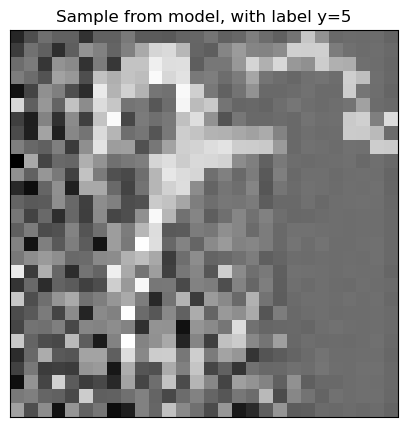

In [104]:
x_t, hist, y = plModule.model.sampling(1, y=True, device='mps', tqdm_disable=False)

fig, ax = plt.subplots(1, 1, figsize=(5, 6))
ax.imshow(x_t.squeeze().detach().cpu().numpy(), cmap='gray')
ax.set_title(f'Sample from model, with label y={y.item()}')
ax.set_xticks([])
ax.set_yticks([])

In [ ]:
# implement tghe following:

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)